# Linear Classification

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(0)  # For reproducibility

# --- Generate Dataset ---
mu1 = np.array([1, 1])
mu2 = np.array([-1, -1])
sigma = np.eye(2)

n_samples = 200
X1 = np.random.multivariate_normal(mu1, sigma, n_samples)
X2 = np.random.multivariate_normal(mu2, sigma, n_samples)

X = np.vstack((X1, X2))
y = np.hstack((np.ones(n_samples), np.zeros(n_samples)))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# --- Gaussian Generative Model (LDA-like) ---
mu1_hat = X_train[y_train == 1].mean(axis=0)
mu2_hat = X_train[y_train == 0].mean(axis=0)

sigma_hat = np.cov(X_train.T)  # shared covariance

# Compute linear decision boundary
sigma_inv = np.linalg.inv(sigma_hat)
w = sigma_inv @ (mu1_hat - mu2_hat)
b = -0.5 * (mu1_hat.T @ sigma_inv @ mu1_hat - mu2_hat.T @ sigma_inv @ mu2_hat)

def predict_gaussian(X):
    return (X @ w + b) > 0

y_pred_gauss = predict_gaussian(X_test)
acc_gauss = accuracy_score(y_test, y_pred_gauss)

# --- Logistic Regression using IRLS ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def IRLS(X, y, max_iter=100, tol=1e-6):
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
    w = np.zeros(X.shape[1])

    for _ in range(max_iter):
        z = X @ w
        y_hat = sigmoid(z)
        R = np.diag(y_hat * (1 - y_hat))
        grad = X.T @ (y - y_hat)
        H = X.T @ R @ X
        delta = np.linalg.inv(H) @ grad
        w += delta

        if np.linalg.norm(delta) < tol:
            break

    return w

# Fit model
w_irls = IRLS(X_train, y_train)

def predict_logistic(X, w):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    return sigmoid(X @ w) > 0.5

y_pred_logistic = predict_logistic(X_test, w_irls)
acc_logistic = accuracy_score(y_test, y_pred_logistic)

# --- Print Results ---
print(f"Gaussian Generative Model Accuracy: {acc_gauss * 100:.2f}%")
print(f"Logistic Regression (IRLS) Accuracy: {acc_logistic * 100:.2f}%")


Gaussian Generative Model Accuracy: 96.25%
Logistic Regression (IRLS) Accuracy: 96.25%


## Plotting ROC Curves

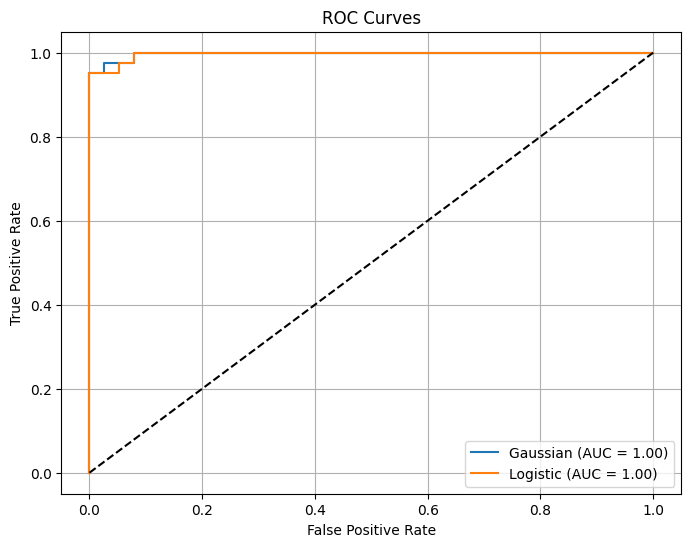

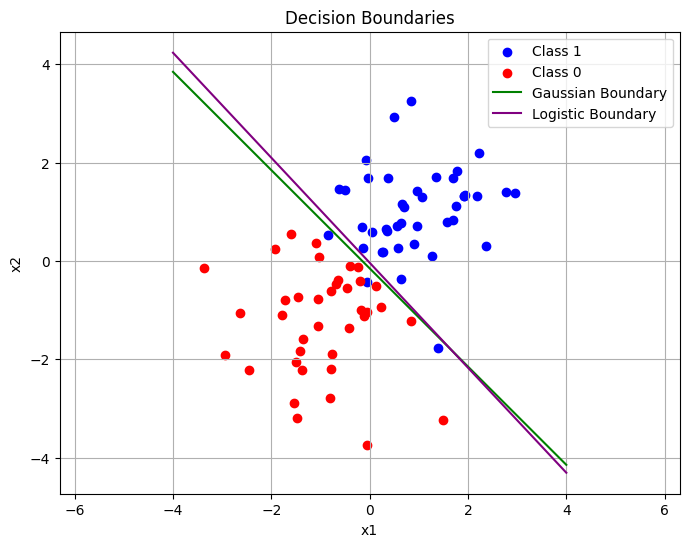

Gaussian Generative Accuracy: 96.25%
Logistic Regression Accuracy: 96.25%


In [5]:
from sklearn.metrics import accuracy_score, roc_curve, auc

np.random.seed(0)

# --- Generate Data ---
mu1 = np.array([1, 1])
mu2 = np.array([-1, -1])
sigma = np.eye(2)

n_samples = 200
X1 = np.random.multivariate_normal(mu1, sigma, n_samples)
X2 = np.random.multivariate_normal(mu2, sigma, n_samples)

X = np.vstack((X1, X2))
y = np.hstack((np.ones(n_samples), np.zeros(n_samples)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# --- Gaussian Generative Model (LDA) ---
mu1_hat = X_train[y_train == 1].mean(axis=0)
mu2_hat = X_train[y_train == 0].mean(axis=0)
sigma_hat = np.cov(X_train.T)
sigma_inv = np.linalg.inv(sigma_hat)

w_gauss = sigma_inv @ (mu1_hat - mu2_hat)
b_gauss = -0.5 * (mu1_hat.T @ sigma_inv @ mu1_hat - mu2_hat.T @ sigma_inv @ mu2_hat)

def gaussian_scores(X):
    return X @ w_gauss + b_gauss

def predict_gaussian(X):
    return gaussian_scores(X) > 0

y_score_gauss = gaussian_scores(X_test)
y_pred_gauss = predict_gaussian(X_test)
acc_gauss = accuracy_score(y_test, y_pred_gauss)

# --- Logistic Regression (IRLS) ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def IRLS(X, y, max_iter=100, tol=1e-6):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    w = np.zeros(X.shape[1])

    for _ in range(max_iter):
        z = X @ w
        y_hat = sigmoid(z)
        R = np.diag(y_hat * (1 - y_hat))
        grad = X.T @ (y - y_hat)
        H = X.T @ R @ X
        delta = np.linalg.inv(H) @ grad
        w += delta
        if np.linalg.norm(delta) < tol:
            break
    return w

w_irls = IRLS(X_train, y_train)

def logistic_scores(X):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    return sigmoid(X_bias @ w_irls)

def predict_logistic(X):
    return logistic_scores(X) > 0.5

y_score_logistic = logistic_scores(X_test)
y_pred_logistic = predict_logistic(X_test)
acc_logistic = accuracy_score(y_test, y_pred_logistic)

# --- ROC Curve ---
fpr_g, tpr_g, _ = roc_curve(y_test, y_score_gauss)
fpr_l, tpr_l, _ = roc_curve(y_test, y_score_logistic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_g, tpr_g, label=f'Gaussian (AUC = {auc(fpr_g, tpr_g):.2f})')
plt.plot(fpr_l, tpr_l, label=f'Logistic (AUC = {auc(fpr_l, tpr_l):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Decision Boundary Plot ---
def plot_decision_boundary(w, b, label, color):
    x_vals = np.linspace(-4, 4, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    plt.plot(x_vals, y_vals, label=label, color=color)

plt.figure(figsize=(8, 6))
plt.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c='blue', label='Class 1')
plt.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c='red', label='Class 0')

# Gaussian boundary
plot_decision_boundary(w_gauss, b_gauss, 'Gaussian Boundary', 'green')

# Logistic boundary
w_l = w_irls[1:]
b_l = w_irls[0]
plot_decision_boundary(w_l, b_l, 'Logistic Boundary', 'purple')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundaries')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Accuracy Report ---
print(f"Gaussian Generative Accuracy: {acc_gauss * 100:.2f}%")
print(f"Logistic Regression Accuracy: {acc_logistic * 100:.2f}%")


# German Credit Data (binary classification w/ numeric features)

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load from UCI:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = [
    'checking', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings', 'employment', 'installment_rate', 'personal_status',
    'other_debtors', 'residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'target'
]
df = pd.read_csv(url, sep=' ', names=cols)

# Select numeric-only features (drop dummy categorical columns)
numeric_cols = [
    'duration', 'credit_amount', 'installment_rate',
    'residence_since', 'age', 'number_credits', 'people_liable'
]
X = df[numeric_cols].values
y = (df['target'] == 1).astype(int).values  # 1 = good, 2 = bad → convert

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Estimate parameters from training set
mu1_hat = X_train[y_train == 1].mean(axis=0)
mu2_hat = X_train[y_train == 0].mean(axis=0)
sigma_hat = np.cov(X_train.T)
sigma_inv = np.linalg.inv(sigma_hat)

# Compute weights and bias
w_gauss = sigma_inv @ (mu1_hat - mu2_hat)
b_gauss = -0.5 * (mu1_hat @ sigma_inv @ mu1_hat - mu2_hat @ sigma_inv @ mu2_hat)

def predict_gaussian(X):
    return (X @ w_gauss + b_gauss) > 0

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def IRLS(X, y, max_iter=100, tol=1e-6):
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # add bias
    w = np.zeros(X.shape[1])
    for _ in range(max_iter):
        z = X @ w
        y_hat = sigmoid(z)
        R = np.diag(y_hat * (1 - y_hat))
        grad = X.T @ (y - y_hat)
        H = X.T @ R @ X
        delta = np.linalg.inv(H) @ grad
        w += delta
        if np.linalg.norm(delta) < tol:
            break
    return w

w_irls = IRLS(X_train, y_train)

def predict_logistic(X):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    return sigmoid(X_bias @ w_irls) > 0.5

acc_gauss = np.mean(predict_gaussian(X_test) == y_test)
acc_logistic = np.mean(predict_logistic(X_test) == y_test)
print(f"Gaussian acc = {acc_gauss*100:.2f}%")
print(f"Logistic acc = {acc_logistic*100:.2f}%")



Gaussian acc = 59.33%
Logistic acc = 71.33%
